# Objetivo
Ser capaz de identificar clientes de alta renda (>50K) a partir de dados demográficos, socio economico e cadastro utilizando modelo de classificação (Regressão Logistica).

O dataset utilizado contém informações fictícias apenas para efeitos acadêmicos. 
Fonte: https://www.kaggle.com/uciml/adult-census-income

O tipo de modelo escolhido foi de Regressão Logística uma vez que a variável que deseja prever é binária (>50K ou <=50K).

Através do modelo, é possível segmentar clientes do banco utilizando dados que podem ser disponibilizados pelas APIs do Open Banking. Esse modelo é um estágio inicial dos diversos serviços que pode-se realizar, podendo adotar uma estratégia de ataque aos novos clientes e também uma estratégia de defesa, em que pode-se selecionar o nicho de clientes que queremos manter na carteira. No próximo estágio, pode-se utilizar outras variáveis, como valor de investimento, crédito e moveimentação bancária no modelo.

O intuito ao utilizar o modelo é oferecer melhores serviços e produtos baseado na renda do cliente.

# Importação das bibliotecas 

In [1]:
!pip install imblearn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from pymongo import MongoClient
sns.set()

# Importação dos dados
Utilização dos dados armazenado no MongoDB.

In [3]:
#Adicionando conexão com mongo
client = MongoClient("mongodb", 27017)

In [4]:
#Carregando database
db = client.raw

In [5]:
#Carregando Collection
dados = db.adults

In [6]:
#Gerando cursor com toda a collection
cursor = dados.find()

In [7]:
#Gerando um Dataframe do Panda
data = pd.DataFrame(list(cursor))

In [8]:
#importação no datafram data
data.head()

,_id,income,finalWeight,education,occupation,hoursPerWeek,race,sex,educationNum,capitalLoss,nativeCountry,workClass,capitalGain,relationship,age,maritalStatus
0,61244322a4238d1ad6f16bfd,<=50k,77516,bachelors,adm-clerical,40,white,male,13,0.0,united-states,state-gov,2174.0,not-in-family,39,never-married
1,61244323a4238d1ad6f16bfe,<=50k,284582,masters,exec-managerial,40,white,female,14,0.0,united-states,private,0.0,wife,37,married-civ-spouse
2,61244323a4238d1ad6f16bff,<=50k,109015,hs-grad,tech-support,40,white,female,9,0.0,united-states,private,0.0,unmarried,59,divorced
3,61244323a4238d1ad6f16c00,<=50k,367260,hs-grad,exec-managerial,80,white,male,9,0.0,united-states,private,0.0,not-in-family,39,divorced
4,61244323a4238d1ad6f16c01,<=50k,311512,some-college,other-service,15,black,male,10,0.0,united-states,state-gov,0.0,husband,22,married-civ-spouse


In [9]:
# Informações dos campos e tipos de cada coluna.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   _id            32561 non-null  object 
 1   income         32561 non-null  object 
 2   finalWeight    32561 non-null  int64  
 3   education      32561 non-null  object 
 4   occupation     32561 non-null  object 
 5   hoursPerWeek   32561 non-null  int64  
 6   race           32561 non-null  object 
 7   sex            32561 non-null  object 
 8   educationNum   32561 non-null  int64  
 9   capitalLoss    32561 non-null  float64
 10  nativeCountry  32561 non-null  object 
 11  workClass      32561 non-null  object 
 12  capitalGain    32561 non-null  float64
 13  relationship   32561 non-null  object 
 14  age            32561 non-null  int64  
 15  maritalStatus  32561 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 4.0+ MB


# Verificação das variáveis

Apesar de mostrar que o dataset não há valores null, percebe-se que existem campos com valor '?' nas variáveis nativeCountry, workclass e occupation.
Abaixo é possível verificar:

In [10]:
data['occupation'].unique()

array(['adm-clerical', 'exec-managerial', 'tech-support', 'other-service',
       'sales', 'machine-op-inspct', 'craft-repair', 'protective-serv',
       'handlers-cleaners', 'prof-specialty', '?', 'transport-moving',
       'farming-fishing', 'priv-house-serv', 'armed-forces'], dtype=object)

In [11]:
data['workClass'].unique()

array(['state-gov', 'private', 'local-gov', 'self-emp-not-inc', '?',
       'federal-gov', 'self-emp-inc', 'without-pay', 'never-worked'],
      dtype=object)

In [12]:
data['nativeCountry'].unique()

array(['united-states', '?', 'cuba', 'canada', 'germany', 'iran',
       'mexico', 'poland', 'cambodia', 'thailand', 'jamaica', 'south',
       'dominican-republic', 'france', 'india', 'honduras', 'puerto-rico',
       'columbia', 'el-salvador', 'taiwan', 'philippines', 'england',
       'portugal', 'japan', 'italy', 'china', 'guatemala', 'nicaragua',
       'vietnam', 'laos', 'trinadad&tobago', 'ecuador', 'yugoslavia',
       'haiti', 'hong', 'greece', 'scotland',
       'outlying-us(guam-usvi-etc)', 'peru', 'ireland', 'hungary',
       'holand-netherlands'], dtype=object)

Abaixo, segue a análise das demais variáveis:

In [13]:
data['age'].unique()

array([39, 37, 59, 22, 31, 24, 41, 25, 28, 18, 52, 46, 44, 49, 30, 29, 47,
       17, 56, 53, 38, 27, 19, 23, 42, 68, 36, 35, 26, 60, 50, 54, 40, 58,
       32, 45, 34, 43, 55, 33, 67, 70, 71, 21, 48, 90, 75, 76, 20, 61, 57,
       66, 51, 64, 72, 65, 63, 77, 62, 74, 69, 79, 80, 81, 73, 88, 78, 82,
       83, 84, 85, 86, 87])

In [14]:
data['education'].unique()

array(['bachelors', 'masters', 'hs-grad', 'some-college', '9th',
       'assoc-voc', '11th', '10th', 'assoc-acdm', '1st-4th', '7th-8th',
       '5th-6th', 'doctorate', 'prof-school', '12th', 'preschool'],
      dtype=object)

In [15]:
data['maritalStatus'].unique()

array(['never-married', 'married-civ-spouse', 'divorced', 'separated',
       'widowed', 'married-spouse-absent', 'married-af-spouse'],
      dtype=object)

In [16]:
data['relationship'].unique()

array(['not-in-family', 'wife', 'unmarried', 'husband', 'own-child',
       'other-relative'], dtype=object)

In [17]:
data['race'].unique()

array(['white', 'black', 'other', 'asian-pac-islander',
       'amer-indian-eskimo'], dtype=object)

In [18]:
data['sex'].unique()

array(['male', 'female'], dtype=object)

In [19]:
data['income'].unique() 

array(['<=50k', '>50k'], dtype=object)

In [20]:
data['finalWeight'].unique() 

array([ 77516, 284582, 109015, ...,  34066,  84661, 257302])

In [21]:
data['hoursPerWeek'].unique() 

array([40, 80, 15, 38, 43, 50, 22, 35, 48, 32, 41, 60, 30, 20, 45, 36, 12,
       34, 75, 16, 25, 70, 24, 72,  5, 55, 13,  6,  2, 42,  8, 52, 58, 28,
       56, 19, 18, 65,  1, 46,  7, 44, 10, 33, 47, 53, 39, 59,  9, 37, 11,
       66, 49, 54,  3, 99, 98, 62, 57, 21, 26, 14,  4, 78, 90, 84, 17, 64,
       27, 85, 68, 31, 51, 77, 63, 23, 73, 87, 88, 89, 97, 94, 29, 96, 67,
       82, 86, 91, 81, 76, 92, 61, 74, 95])

In [22]:
data['educationNum'].unique() 

array([13, 14,  9, 10,  5, 11,  7,  6, 12,  2,  4,  3, 16, 15,  8,  1])

In [23]:
data['capitalLoss'].unique() 

array([   0., 1573., 1887., 1876., 1564., 1816., 1980., 1408., 1902.,
       2206., 1977., 1719., 1762., 1672., 1669., 2352.,  653., 2415.,
       1628., 1741., 1848., 2339., 1579., 2179., 1340., 2174., 1590.,
       1485., 1504., 1651., 2051., 2377., 1740., 1602.,  419., 2547.,
       2042., 1380., 1138., 2392., 1721., 2001., 2002., 2258., 1726.,
       2205., 2444., 2238.,  625.,  213., 1539.,  880., 1668., 1092.,
       1594., 3004., 2231., 1844.,  810., 2824., 2559., 2057., 1974.,
        974., 2149., 1825., 1735., 2129., 1258., 2603., 2282.,  323.,
       4356., 2246., 1617., 1648., 2489., 3770., 1755., 3683., 2267.,
       2080., 2457.,  155., 2201., 3900., 1944., 2467., 2163., 2754.,
       2472., 1411.])

In [24]:
data['capitalGain'].unique() 

array([ 2174.,     0., 14344., 34095.,  7298.,  4064.,  4386.,  7688.,
        5178.,  5013., 15024.,  6849.,  2176.,   594., 25236.,  2463.,
        4101.,  3464.,  3103., 20051.,  3411.,  9386.,  1055.,  1409.,
        8614., 99999.,  2105.,  3325.,  4650.,  6767.,  3781.,  3137.,
        3674.,  1506.,  1111.,  4787., 10605.,  3471.,  2407.,  2050.,
        1471.,  2329., 25124.,  2597.,  2202., 14084.,  2961.,  4865.,
       27828.,  5556., 10520.,  6514.,  2228.,  3818.,  3942.,  2829.,
        2977.,  2062.,  2964., 13550.,  2635.,  2580., 15020.,  2885.,
         914.,  4934.,   401.,  2354.,  1424., 22040.,  3273.,  5455.,
        4416.,  3908., 10566.,   991.,  4931.,  1086.,  7430.,  6497.,
        7896.,   114.,  2346.,  3418.,  3432.,  2907.,  1151.,  2414.,
        2290., 15831., 41310.,  4508.,  2538.,  3456.,  6418.,  1848.,
        3887.,  5721.,  9562.,  1455.,  2036.,  1831., 11678.,  2936.,
        2993.,  7443.,  6360.,  1797.,  1173.,  4687.,  2009.,  6723.,
      

# Tratamento das variáveis com valores null e/ou inconsistêntes (Data Wrangling)


Substituição dos valores '?' de todo dataframe para NaN.

In [25]:
data = data.replace('?', np.nan)
data.head()

,_id,income,finalWeight,education,occupation,hoursPerWeek,race,sex,educationNum,capitalLoss,nativeCountry,workClass,capitalGain,relationship,age,maritalStatus
0,61244322a4238d1ad6f16bfd,<=50k,77516,bachelors,adm-clerical,40,white,male,13,0.0,united-states,state-gov,2174.0,not-in-family,39,never-married
1,61244323a4238d1ad6f16bfe,<=50k,284582,masters,exec-managerial,40,white,female,14,0.0,united-states,private,0.0,wife,37,married-civ-spouse
2,61244323a4238d1ad6f16bff,<=50k,109015,hs-grad,tech-support,40,white,female,9,0.0,united-states,private,0.0,unmarried,59,divorced
3,61244323a4238d1ad6f16c00,<=50k,367260,hs-grad,exec-managerial,80,white,male,9,0.0,united-states,private,0.0,not-in-family,39,divorced
4,61244323a4238d1ad6f16c01,<=50k,311512,some-college,other-service,15,black,male,10,0.0,united-states,state-gov,0.0,husband,22,married-civ-spouse


Abaixo, nota-se as variáveis com NaN. As variáveis que possuem NaN são occupation, nativeCountry e workClass, confirmando as análises acima (In[15], In[16] e In[17])

In [26]:
data.isna().sum()

_id                 0
income              0
finalWeight         0
education           0
occupation       1843
hoursPerWeek        0
race                0
sex                 0
educationNum        0
capitalLoss         0
nativeCountry     583
workClass        1836
capitalGain         0
relationship        0
age                 0
maritalStatus       0
dtype: int64

Para as variáveis Workclass e Occupation pode-se verificar as dependências entre as mesmas.

In [27]:
data[data['workClass'].isna()]['occupation'].unique()

array([nan], dtype=object)

In [28]:
data[data['occupation'].isna()]['income'].value_counts()

<=50k    1652
>50k      191
Name: income, dtype: int64

Nota-se que os NaN em workclass depende de occupation (como esperado) - tipo MAR (Missing at Random). 
Sendo assim, pode-se afirmar que os valores NaN são de pessoas desempregadas. Assim, os valores podem ser substituido para "Unemployee"

In [29]:
data['occupation'] = data['occupation'].fillna('unemployed')
data['workClass'] = data['workClass'].fillna('unemployed')
data.head()

,_id,income,finalWeight,education,occupation,hoursPerWeek,race,sex,educationNum,capitalLoss,nativeCountry,workClass,capitalGain,relationship,age,maritalStatus
0,61244322a4238d1ad6f16bfd,<=50k,77516,bachelors,adm-clerical,40,white,male,13,0.0,united-states,state-gov,2174.0,not-in-family,39,never-married
1,61244323a4238d1ad6f16bfe,<=50k,284582,masters,exec-managerial,40,white,female,14,0.0,united-states,private,0.0,wife,37,married-civ-spouse
2,61244323a4238d1ad6f16bff,<=50k,109015,hs-grad,tech-support,40,white,female,9,0.0,united-states,private,0.0,unmarried,59,divorced
3,61244323a4238d1ad6f16c00,<=50k,367260,hs-grad,exec-managerial,80,white,male,9,0.0,united-states,private,0.0,not-in-family,39,divorced
4,61244323a4238d1ad6f16c01,<=50k,311512,some-college,other-service,15,black,male,10,0.0,united-states,state-gov,0.0,husband,22,married-civ-spouse


Tratamento da variável nativeCountry

In [30]:
data[data['nativeCountry'].isna()]

,_id,income,finalWeight,education,occupation,hoursPerWeek,race,sex,educationNum,capitalLoss,nativeCountry,workClass,capitalGain,relationship,age,maritalStatus
5,61244323a4238d1ad6f16c02,>50k,84154,some-college,sales,38,white,male,10,0.0,NaN,private,0.0,husband,31,married-civ-spouse
18,61244323a4238d1ad6f16c0f,<=50k,117747,hs-grad,sales,35,asian-pac-islander,female,9,1573.0,NaN,private,0.0,wife,30,married-civ-spouse
151,61244324a4238d1ad6f16c94,<=50k,293936,7th-8th,unemployed,40,white,male,4,0.0,NaN,unemployed,0.0,not-in-family,32,married-spouse-absent
332,61244326a4238d1ad6f16d49,<=50k,201624,bachelors,prof-specialty,45,black,male,13,0.0,NaN,private,0.0,not-in-family,30,never-married
341,61244326a4238d1ad6f16d52,<=50k,239683,10th,craft-repair,30,white,male,6,0.0,NaN,private,0.0,husband,41,married-civ-spouse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32485,612443cca4238d1ad6f1eae2,>50k,71556,masters,sales,50,white,male,14,0.0,NaN,self-emp-inc,0.0,husband,44,married-civ-spouse
32496,612443cca4238d1ad6f1eaed,<=50k,181974,doctorate,prof-specialty,99,white,female,16,0.0,NaN,self-emp-inc,0.0,not-in-family,58,never-married
32500,612443cca4238d1ad6f1eaf1,<=50k,217597,hs-grad,sales,50,white,male,9,0.0,NaN,self-emp-not-inc,0.0,own-child,42,divorced
32544,612443cca4238d1ad6f1eb1d,>50k,107302,hs-grad,prof-specialty,45,white,male,9,0.0,NaN,private,0.0,husband,39,married-civ-spouse


Pode-se notar acima que a variável nativeCountry NaN são erro de preenchimento ou ausência dos dados. Não há relação com outras variáveis. 
A exclusão desses registros com 'native.country' NaN é necessária para evitar um resultado enviesado (são 583 registros).

In [31]:
data.isna().sum()

_id                0
income             0
finalWeight        0
education          0
occupation         0
hoursPerWeek       0
race               0
sex                0
educationNum       0
capitalLoss        0
nativeCountry    583
workClass          0
capitalGain        0
relationship       0
age                0
maritalStatus      0
dtype: int64

In [32]:
data.dropna(inplace = True)
data.head()

,_id,income,finalWeight,education,occupation,hoursPerWeek,race,sex,educationNum,capitalLoss,nativeCountry,workClass,capitalGain,relationship,age,maritalStatus
0,61244322a4238d1ad6f16bfd,<=50k,77516,bachelors,adm-clerical,40,white,male,13,0.0,united-states,state-gov,2174.0,not-in-family,39,never-married
1,61244323a4238d1ad6f16bfe,<=50k,284582,masters,exec-managerial,40,white,female,14,0.0,united-states,private,0.0,wife,37,married-civ-spouse
2,61244323a4238d1ad6f16bff,<=50k,109015,hs-grad,tech-support,40,white,female,9,0.0,united-states,private,0.0,unmarried,59,divorced
3,61244323a4238d1ad6f16c00,<=50k,367260,hs-grad,exec-managerial,80,white,male,9,0.0,united-states,private,0.0,not-in-family,39,divorced
4,61244323a4238d1ad6f16c01,<=50k,311512,some-college,other-service,15,black,male,10,0.0,united-states,state-gov,0.0,husband,22,married-civ-spouse


Verificar se existe alguma variável com valor NaN.

In [33]:
data.isna().sum()

_id              0
income           0
finalWeight      0
education        0
occupation       0
hoursPerWeek     0
race             0
sex              0
educationNum     0
capitalLoss      0
nativeCountry    0
workClass        0
capitalGain      0
relationship     0
age              0
maritalStatus    0
dtype: int64

Tratamento das variáveis 'educationNum' e _id

educationNum é uma forma numérica da coluna 'education'

_id é uma variável criado pelo MongoDB

Obta-se para remoção dessas variáveis para evitar enviesamento no modelo.

In [34]:
data.drop('educationNum', axis = 1,inplace = True)

In [35]:
data.drop('_id', axis = 1,inplace = True)

Simplificação dos valores das variáveis education, workclass e marital status

- Variável education

In [36]:
data['education'].value_counts()

hs-grad         10368
some-college     7187
bachelors        5210
masters          1674
assoc-voc        1366
11th             1167
assoc-acdm       1055
10th              921
7th-8th           627
prof-school       559
9th               506
12th              417
doctorate         390
5th-6th           318
1st-4th           163
preschool          50
Name: education, dtype: int64

In [37]:
hs_grad = ['hs-grad','11th','10th','9th','12th']
elementary = ['1st-4th','5th-6th','7th-8th']

data['education'].replace(hs_grad,'HighSchool-grad', inplace=True)
data['education'].replace(elementary,'elementary_school', inplace=True)

data['education'].value_counts()

HighSchool-grad      13379
some-college          7187
bachelors             5210
masters               1674
assoc-voc             1366
elementary_school     1108
assoc-acdm            1055
prof-school            559
doctorate              390
preschool               50
Name: education, dtype: int64

- Variável workClass

In [38]:
data['workClass'].value_counts()

private             22286
self-emp-not-inc     2499
local-gov            2067
unemployed           1809
state-gov            1279
self-emp-inc         1074
federal-gov           943
without-pay            14
never-worked            7
Name: workClass, dtype: int64

In [39]:
self_employed = ['self-emp-not-inc','self-emp-inc']
govt_employees = ['local-gov','state-gov','federal-gov']

data['workClass'].replace(to_replace = self_employed ,value = 'self_employed',inplace = True)
data['workClass'].replace(to_replace = govt_employees,value = 'govern_employees',inplace = True)

data['workClass'].value_counts()

private             22286
govern_employees     4289
self_employed        3573
unemployed           1809
without-pay            14
never-worked            7
Name: workClass, dtype: int64

- Variável maritalStatus

In [40]:
data['maritalStatus'].value_counts()

married-civ-spouse       14692
never-married            10488
divorced                  4394
separated                 1005
widowed                    979
married-spouse-absent      397
married-af-spouse           23
Name: maritalStatus, dtype: int64

In [41]:
married= ['married-spouse-absent','married-civ-spouse','married-af-spouse']
separated = ['separated','divorced']

data['maritalStatus'].replace(to_replace = married ,value = 'married',inplace = True)
data['maritalStatus'].replace(to_replace = separated,value = 'separated',inplace = True)

data['maritalStatus'].value_counts()

married          15112
never-married    10488
separated         5399
widowed            979
Name: maritalStatus, dtype: int64

In [42]:
((data['income'].values == '>50k').sum() ) & ((data['workClass'].values == 'self_employed').sum() )

3077

In [43]:
((data['income'].values == '>50k').sum() ) & ((data['workClass'].values == 'self_employed').sum() )

3077

In [44]:
((data['income'].values == '>50k').sum() ) & ((data['workClass'].values == 'self_employed').sum() )

3077

- Variável Sex

In [45]:
data['sex'].value_counts()

male      21370
female    10608
Name: sex, dtype: int64

In [46]:
data['sex'].replace('male', 0, inplace=True)
data['sex'].replace('female', 1, inplace=True)
data['sex'].value_counts()

0    21370
1    10608
Name: sex, dtype: int64

# Análise dos dados

Rate e correlação entre 2 fatores diferentes (workClass e maritalStatus)

- Análise workClass

In [47]:
total_client_count = len(data['workClass'])
total_clientVIP_count = ((data['income'].values == '>50k').sum() ) 

private_count = (data['workClass'].values == 'private').sum() 
govern_count = (data['workClass'].values == 'govern_employees').sum() 
self_count = (data['workClass'].values == 'self_employed').sum() 
unemployed_count = (data['workClass'].values == 'unemployed').sum()          
withoutpay_count = (data['workClass'].values == 'without-pay').sum() 
neverworked_count = (data['workClass'].values == 'never-worked').sum() 

vprivate_count = ((data['income'].values == '>50k').sum() ) & ((data['workClass'].values == 'private').sum() )
vgovern_count = ((data['income'].values == '>50k').sum() ) & ((data['workClass'].values == 'govern_employees').sum() )
vself_count = ((data['income'].values == '>50k').sum() ) & ((data['workClass'].values == 'self_employed').sum() )
vunemployed_count = ((data['income'].values == '>50k').sum() ) & ((data['workClass'].values == 'unemployed').sum() )
vwithoutpay_count = ((data['income'].values == '>50k').sum() ) & ((data['workClass'].values == 'without-pay').sum() )
vneverworked_count = ((data['income'].values == '>50k').sum() ) & ((data['workClass'].values == 'never-worked').sum() )

perc_private = private_count / total_client_count * 100
perc_govern = govern_count / total_client_count * 100
perc_self = self_count / total_client_count * 100
perc_unemployed = unemployed_count / total_client_count * 100       
perc_withoutpay = withoutpay_count/ total_client_count * 100
perc_neverworked = neverworked_count / total_client_count * 100

vperc_private = vprivate_count / total_clientVIP_count * 100
vperc_govern = vgovern_count / total_clientVIP_count * 100
vperc_self = vself_count / total_clientVIP_count * 100
vperc_unemployed = vunemployed_count / total_clientVIP_count * 100       
vperc_withoutpay = vwithoutpay_count/ total_clientVIP_count * 100
vperc_neverworked = vneverworked_count / total_clientVIP_count * 100

In [48]:
print('private percentage = ', perc_private, ' | VIP percentage: ', vperc_private)
print('govern percentage = ', perc_govern,  ' | VIP percentage: ', vperc_govern)
print('self percentage = ', perc_self,  ' | VIP percentage: ', vperc_self)
print('unemployed percentage = ', perc_unemployed,  ' | VIP percentage: ', vperc_unemployed)
print('withoupay percentage = ', perc_withoutpay, ' | VIP percentage: ', vperc_withoutpay)
print('never worked percentage = ', perc_neverworked,  ' | VIP percentage: ', vperc_neverworked)

private percentage =  69.6916630183251  | VIP percentage:  73.37231968810917
govern percentage =  13.412345987866658  | VIP percentage:  53.24236517218973
self percentage =  11.17330664832072  | VIP percentage:  39.98700454840806
unemployed percentage =  5.657014197260617  | VIP percentage:  19.974009096816115
withoupay percentage =  0.04378009881793733  | VIP percentage:  0.18193632228719947
never worked percentage =  0.021890049408968666  | VIP percentage:  0.09096816114359974


Conclusão:

- A pessoa que trabalha em empresa privada representa 69% da base de dados, mas 73% desses clientes são de alta renda (>50k)
- A pessoa que trabalha em empresa do governo representa 13% da base de dados, mas 53% desses clientes são de alta renda (>50k)
- A pessoa que trabalha por conta própria representa 11% da base de dados, mas 39% desses clientes são de alta renda (>50k)
- A pessoa que está desempregada representa 5% da base de dados, mas 19% desses clientes são de alta renda (>50k)
- A pessoa que não tem renda representa menos de 1% da base de dados, mas menos de 1% desses clientes são de alta renda (>50k)
- A pessoa que nunca trabalhou menos de 1% da base de dados, mas menos de 1% desses clientes são de alta renda (>50k)

O foco para estratégias de ataque e defesa podem se norteado através do tipo de empresa do cadastro do cliente, ao verificar os percentuais dos clientes que não possuem renda ou nunca trabalhou, mostra um baixo percentual de ter um cliente premium. Além disso, nota-se considerar a classe de empresa privada e governo com grande parcela e probabilidade de ter um cliente de alta renda. Outra classe que demonstra um grande grande potencial a ser explorado são os cliente desempregado, mas com grande rendas, representando um total de 19%.

- Análise maritalStatus

In [49]:
total_client_count = len(data['maritalStatus'])
total_clientVIP_count = ((data['income'].values == '>50k').sum() ) 

married_count = (data['maritalStatus'].values == 'married').sum() 
never_count = (data['maritalStatus'].values == 'never-married').sum() 
separa_count = (data['maritalStatus'].values == 'separated').sum() 
widowed_count = (data['maritalStatus'].values == 'widowed').sum()          

vmarried_count = ((data['income'].values == '>50k').sum() ) & ((data['maritalStatus'].values == 'married').sum() )
vnever_count = ((data['income'].values == '>50k').sum() ) & ((data['maritalStatus'].values == 'never-married').sum() )
vsepara_count = ((data['income'].values == '>50k').sum() ) & ((data['maritalStatus'].values == 'separated').sum() )
vwidowed_count = ((data['income'].values == '>50k').sum() ) & ((data['maritalStatus'].values == 'widowed').sum() )

perc_married = married_count / total_client_count * 100
perc_never = never_count / total_client_count * 100
perc_separa = separa_count / total_client_count * 100
perc_widowed = widowed_count / total_client_count * 100       

vperc_married = vmarried_count / total_clientVIP_count * 100
vperc_never = vnever_count / total_clientVIP_count * 100
vperc_separa = vsepara_count / total_clientVIP_count * 100
vperc_widowed = vwidowed_count / total_clientVIP_count * 100    

In [50]:
print('married percentage = ', perc_married ,' | VIP percentage: ', vperc_married )
print('never-married percentage = ', perc_never ,' | VIP percentage: ', vperc_never )
print('separated percentage = ', perc_separa ,' | VIP percentage: ', vperc_separa )
print('widowed percentage = ', perc_widowed ,' | VIP percentage: ', vperc_widowed )


married percentage =  47.257489524047784  | VIP percentage:  86.60168940870695
never-married percentage =  32.7975483144662  | VIP percentage:  26.71864847303444
separated percentage =  16.883482394145975  | VIP percentage:  66.62768031189084
widowed percentage =  3.0614797673400465  | VIP percentage:  6.692657569850552


Conclusão:

- A pessoa que é casada representa 47% da base de dados, mas 86% desses clientes são de alta renda (>50k)
- A pessoa que é solteira representa 32% da base de dados, mas 26% desses clientes são de alta renda (>50k)
- A pessoa que é separada representa 16% da base de dados, mas 66% desses clientes são de alta renda (>50k)
- A pessoa que é viuvo(a) representa 3% da base de dados, mas 6% desses clientes são de alta renda (>50k)

O foco para estratégias de ataque e defesa podem se norteado através do estado cívil do cliente, tem alto potencial aos clientes que são casados e separado, podendo realizar uma estratégia para atingir essas pessoas. Além disso, o potencial para solteiro e um nicho pouco explorado pode ser os solteiros, que representam 26% dos clientes alta renda.

# Transformação das variáveis categóricas em númericos para utilizar no modelo

- Variável inCome

Essa é a variável target, sendo considerado <=50k igual à 0 e >=50k igual à 1.

In [51]:
data['income'].value_counts(normalize=True)

<=50k    0.759366
>50k     0.240634
Name: income, dtype: float64

In [52]:
data.replace('<=50k', 0, inplace=True)
data.replace('>50k', 1, inplace=True)

In [53]:
data['income'].value_counts()

0    24283
1     7695
Name: income, dtype: int64

- Mudança para as demais variáveis

In [54]:
data = pd.get_dummies(data)
data.head() 

,income,finalWeight,hoursPerWeek,sex,capitalLoss,capitalGain,age,education_HighSchool-grad,education_assoc-acdm,education_assoc-voc,...,relationship_husband,relationship_not-in-family,relationship_other-relative,relationship_own-child,relationship_unmarried,relationship_wife,maritalStatus_married,maritalStatus_never-married,maritalStatus_separated,maritalStatus_widowed
0,0,77516,40,0,0.0,2174.0,39,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,284582,40,1,0.0,0.0,37,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,0,109015,40,1,0.0,0.0,59,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,367260,80,0,0.0,0.0,39,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,311512,15,0,0.0,0.0,22,0,0,0,...,1,0,0,0,0,0,1,0,0,0


## Correlação entre as variáveis

In [55]:
# Utilização do modelo de Pearson
data.corr(method ='pearson')

,income,finalWeight,hoursPerWeek,sex,capitalLoss,capitalGain,age,education_HighSchool-grad,education_assoc-acdm,education_assoc-voc,...,relationship_husband,relationship_not-in-family,relationship_other-relative,relationship_own-child,relationship_unmarried,relationship_wife,maritalStatus_married,maritalStatus_never-married,maritalStatus_separated,maritalStatus_widowed
income,1.000000,-0.009014,0.230448,-0.216070,0.149353,0.222703,0.233601,-0.204719,0.003330,0.010236,...,0.400973,-0.188240,-0.083111,-0.229401,-0.142525,0.124217,0.435421,-0.318622,-0.151382,-0.064369
finalWeight,-0.009014,1.000000,-0.018885,-0.025624,-0.010139,0.001087,-0.076704,0.012194,0.005760,-0.016090,...,-0.022869,0.008223,0.025146,0.014580,0.004950,-0.016157,-0.026680,0.038154,0.000322,-0.027357
hoursPerWeek,0.230448,-0.018885,1.000000,-0.229645,0.053106,0.079112,0.068299,-0.063097,0.001506,0.021098,...,0.246770,0.007520,-0.050986,-0.250196,-0.036118,-0.064233,0.211648,-0.199554,0.018204,-0.109121
sex,-0.216070,-0.025624,-0.229645,1.000000,-0.045840,-0.049508,-0.089035,-0.011201,0.024180,0.012763,...,-0.580988,0.171331,0.041501,0.101214,0.320725,0.318290,-0.422661,0.172006,0.260807,0.189005
capitalLoss,0.149353,-0.010139,0.053106,-0.045840,1.000000,-0.031499,0.057282,-0.044940,0.002330,-0.008465,...,0.076109,-0.017599,-0.014762,-0.050427,-0.039250,0.015049,0.077542,-0.060489,-0.025980,-0.003380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
relationship_wife,0.124217,-0.016157,-0.064233,0.318290,0.015049,0.014509,0.020691,-0.016552,0.019983,0.011920,...,-0.185147,-0.131344,-0.039320,-0.096694,-0.077222,1.000000,0.237141,-0.156816,-0.101169,-0.039891
maritalStatus_married,0.435421,-0.026680,0.211648,-0.422661,0.077542,0.082721,0.318117,-0.039056,-0.010369,0.015941,...,0.871362,-0.523258,-0.109789,-0.384131,-0.299369,0.237141,1.000000,-0.661276,-0.426621,-0.168218
maritalStatus_never-married,-0.318622,0.038154,-0.199554,0.172006,-0.060489,-0.065517,-0.534035,-0.004319,-0.005599,-0.030638,...,-0.576211,0.295850,0.108865,0.510830,-0.054323,-0.156816,-0.661276,1.000000,-0.314859,-0.124150
maritalStatus_separated,-0.151382,0.000322,0.018204,0.260807,-0.025980,-0.022649,0.123214,0.038780,0.025181,0.017492,...,-0.371742,0.270604,0.001115,-0.096500,0.393405,-0.101169,-0.426621,-0.314859,1.000000,-0.080095


De acordo com as correlações, decidiu-se retirar as variaveis finalWeight, capitalGain, capitalLoss e hoursPerWeek

In [56]:
data.drop('finalWeight', axis = 1,inplace = True)
data.drop('capitalGain', axis = 1,inplace = True)
data.drop('capitalLoss', axis = 1,inplace = True)
data.drop('hoursPerWeek', axis = 1,inplace = True)

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31978 entries, 0 to 32560
Data columns (total 90 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   income                                    31978 non-null  int64
 1   sex                                       31978 non-null  int64
 2   age                                       31978 non-null  int64
 3   education_HighSchool-grad                 31978 non-null  uint8
 4   education_assoc-acdm                      31978 non-null  uint8
 5   education_assoc-voc                       31978 non-null  uint8
 6   education_bachelors                       31978 non-null  uint8
 7   education_doctorate                       31978 non-null  uint8
 8   education_elementary_school               31978 non-null  uint8
 9   education_masters                         31978 non-null  uint8
 10  education_preschool                       31978 non-null  

# Estatística descritiva das variáveis

Com finalidade de entender cada variáveis é necessário entender o comportamento da mesma. Dessa forma, é possível visualizar a quantidade, media, desvio padrão, mínimo, máximo e quartis.

In [58]:
print(data.shape)
data.describe().transpose()

(31978, 90)


,count,mean,std,min,25%,50%,75%,max
income,31978.0,0.240634,0.427475,0.0,0.0,0.0,0.0,1.0
sex,31978.0,0.331728,0.470841,0.0,0.0,0.0,1.0,1.0
age,31978.0,38.579023,13.662085,17.0,28.0,37.0,48.0,90.0
education_HighSchool-grad,31978.0,0.418381,0.493301,0.0,0.0,0.0,1.0,1.0
education_assoc-acdm,31978.0,0.032991,0.178617,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
relationship_wife,31978.0,0.047970,0.213707,0.0,0.0,0.0,0.0,1.0
maritalStatus_married,31978.0,0.472575,0.499255,0.0,0.0,0.0,1.0,1.0
maritalStatus_never-married,31978.0,0.327975,0.469483,0.0,0.0,0.0,1.0,1.0
maritalStatus_separated,31978.0,0.168835,0.374612,0.0,0.0,0.0,0.0,1.0


# Aplicação do modelo Regressão Logística

Verificação do balanceamento da variável income.

0    24283
1     7695
Name: income, dtype: int64


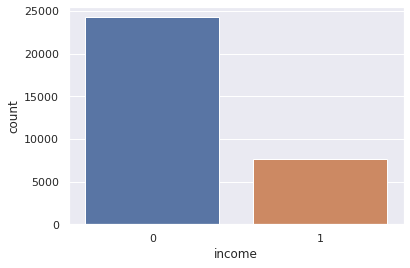

In [59]:
print(data['income'].value_counts())
sns.countplot(x='income', data=data)
plt.show()

Nota-se que a base tende a ter mais dados para a classe income = 1, dessa forma o modelo estará aprendendo mais com a classe majoritária (income = 0) e assim fazendo com que o modelo fique enviessado

Com a finalidade de teste, abaixo tem os passos para o modelo com dados desbalanceados.

In [60]:
# modelo regressão logística, vamos limitar as interações do modelo para 30000, devido ao ambiente POC.
lr = LogisticRegression(max_iter=30000)

In [61]:
# separação das bases, sendo x a variavel target e y as demais variáveis
x = data.drop('income'  , axis = 1)
y = data.income

In [62]:
# separação das bases de treino e teste, considerando a base 70% treino e 30% teste - padrão)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1, stratify=y)

In [63]:
# processamento do modelo
lr.fit(x_train, y_train)

LogisticRegression(max_iter=30000)

In [64]:
# criação do predicto para avaliar o percentual de accuracudade do modelo
y_pred = lr.predict(x_test)

In [65]:
# accuracidade do modelo
print(accuracy_score(y_test, y_pred)*100)

82.98936835522201


In [66]:
# Relatório de precisão e recall do modelo aplicado
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      6071
           1       0.70      0.52      0.59      1924

    accuracy                           0.83      7995
   macro avg       0.78      0.72      0.74      7995
weighted avg       0.82      0.83      0.82      7995



In [67]:
# Matriz da confusão
print(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito     0     1   All
Real                     
0        5643   428  6071
1         932   992  1924
All      6575  1420  7995


# Conclusão

Os resultados acima demonstra que o recall (número de acerto) para a classe 1 é baixa, cerca de 52%. Ou seja, confirma a teoria que o desbalanceamento fará com que o modelo aprenda mais sobre a classe majoritária.

Sendo assim, vamos usar técnicas para balancear as classes. 

# Técnica de Balanceamento - UnderSampling (nearMiss)
Com a finalidade de diminuir o recall e precisão do modelo, a aplicação do nearMiss pode ajudar na melhoria dos resultados de aprendizado.

In [68]:
# aplincando a função NearMiss
nr = NearMiss()

In [69]:
# resample do x e y com função NearMiss
x, y = nr.fit_resample(x, y)

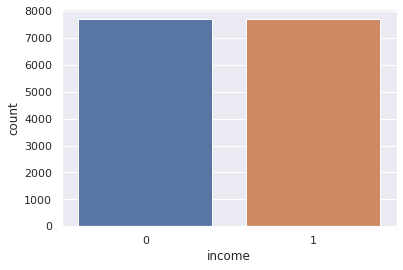

In [70]:
# verificando a base 
ax = sns.countplot(x=y)

In [71]:
# separação das bases de treino e teste, considerando a base 70% treino e 30% teste - padrão)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1, stratify=y)

In [72]:
# modelo regressão logística, vamos limitar as interações do modelo para 30000, devido ao ambiente POC.
lr = LogisticRegression(max_iter=30000)

In [73]:
# processamento do modelo
lr.fit(x_train, y_train)

LogisticRegression(max_iter=30000)

In [74]:
# criação do predicto para avaliar o percentual de accuracudade do modelo
y_pred = lr.predict(x_test)

In [75]:
# accuracidade do modelo
print(accuracy_score(y_test, y_pred)*100)

69.41268191268192


In [76]:
# Relatório de precisão e recall do modelo aplicado
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1924
           1       0.71      0.67      0.69      1924

    accuracy                           0.69      3848
   macro avg       0.69      0.69      0.69      3848
weighted avg       0.69      0.69      0.69      3848



In [77]:
# Matriz da confusão
print(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito     0     1   All
Real                     
0        1391   533  1924
1         644  1280  1924
All      2035  1813  3848


# Conclusão

Os resultados acima demonstram uma melhora com relação ao percentual de acerto entre as duas classes, entretanto a acuracidade do modelo ficou em 70%.

Sendo assim, vamos usar técnicas para balancear as classes, mas no modelo OverSampling. 

# Técnica de Balanceamento - OverSampling (SMOTE)
Com a finalidade de diminuir o recall e precisão do modelo, a aplicação do SMOTE pode ajudar na melhoria dos resultados de aprendizado.

In [78]:
# Necessário recriar o x e y com os dados 
x = data.drop('income', axis = 1)
y = data.income

In [79]:
# verificar se x e y estão corretos
np.bincount(y)

array([24283,  7695])

In [80]:
# aplicando a função SMOTE 
smt = SMOTE()

In [81]:
# resample do x e y com função SMOTE
x, y = smt.fit_resample(x, y)

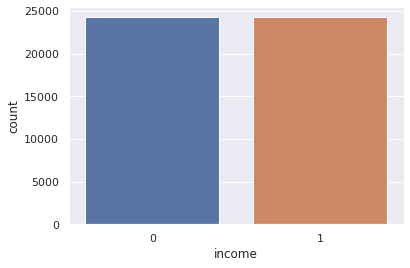

In [82]:
# verificando a base 
ax = sns.countplot(x=y)

In [83]:
# separação das bases de treino e teste, considerando a base 70% treino e 30% teste - padrão)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1, stratify=y)

In [84]:
# modelo regressão logística, vamos limitar as interações do modelo para 30000, devido ao ambiente POC.
lr = LogisticRegression(max_iter=30000)

In [85]:
# processamento do modelo
lr.fit(x_train, y_train)

LogisticRegression(max_iter=30000)

In [86]:
# criação do predicto para avaliar o percentual de accuracudade do modelo
y_pred = lr.predict(x_test)

In [87]:
# accuracidade do modelo
print(accuracy_score(y_test, y_pred)*100)

84.73068687201449


In [88]:
# Relatório de precisão e recall do modelo aplicado
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      6071
           1       0.83      0.88      0.85      6071

    accuracy                           0.85     12142
   macro avg       0.85      0.85      0.85     12142
weighted avg       0.85      0.85      0.85     12142



In [89]:
# Matriz da confusão
print(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito     0     1    All
Real                      
0        4958  1113   6071
1         741  5330   6071
All      5699  6443  12142


# Conclusão

Os resultados acima demonstram uma melhora significativa, com acuracidade de 85% de acerto do modelo, com relação a base balanceada com NearMiss e desbalanceada, com 75% e 82% de acuracidade respectivamente. Além disso, nota-se que a acuracidade entre a classe foi boa, considerando 87% de acerto para clientes abaixo de 50K e 83% para o público alvo.

# Verificação da importância de cada variáveis

In [90]:
importances = pd.DataFrame(data={
    'Attribute': x.columns,
    'Importance': lr.coef_[0]
})

In [91]:
importances = importances.sort_values(by='Importance', ascending=False)

In [92]:
print(importances)

                           Attribute  Importance
1                                age    0.020908
46  nativeCountry_holand-netherlands   -0.015046
41              nativeCountry_france   -0.051302
55               nativeCountry_japan   -0.221846
32            nativeCountry_cambodia   -0.239415
..                               ...         ...
16        occupation_farming-fishing   -4.736935
82            relationship_own-child   -4.772280
17      occupation_handlers-cleaners   -4.840003
19          occupation_other-service   -4.895265
7        education_elementary_school   -6.013428

[89 rows x 2 columns]


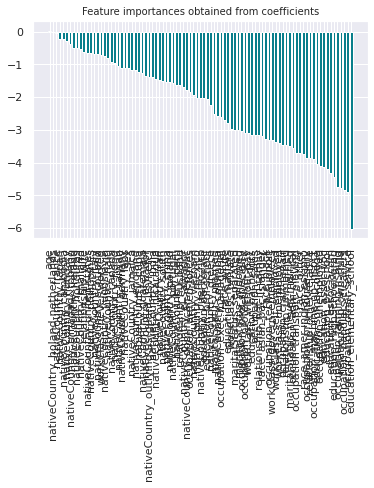

In [93]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=10)
plt.xticks(rotation='vertical')
plt.show()

# Conclusão
tbd